<a href="https://colab.research.google.com/github/tentenvi/tteessstt/blob/main/lab4/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Методы кластеризации и оценка качества кластеризации

Загрузите набор данных из файла cluster datasets в соответствии с вашим вариантом (если считаете, что набор данных не представляет необходимой информации или сложен для интерперетации или, то можно выбрать другой - но **необходимо предварительное согласование**).

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from detectorusoutlierus import outliers as do
from statistics import median, mean, stdev
from math import erfc
from sklearn.cluster import DBSCAN

df = pd.read_csv("/content/ds_salaries.csv") # чтение файла
del df['work_year']
df

,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...
3750,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [ ]:
# plt.scatter(df["salary"], df["company_size"])
# plt.xlabel('salary')
# plt.ylabel('company_size')
# plt.title('Распределение данных в двумерном пространстве')


Используйте представленные в практике методы кластеризации (помните, что кластеры строятся по классам).

Несколько правил перед выполнением задания:
0. Внимательно изучить практику 4!
1. Служебные комментарии читать внимательно и не удалять
2. Выполнить до 10-11-2023 (но не затягивать, таск не простой!)


P.S. Мгномерные данные - данные, в которых количество колонок > 3

P.S.S. Служебные комментарии - ячейки с описанием задачи в """ task description """



In [ ]:
"""
Предварительно - оптимизируйте ваш набор данных.
1. Удалить лишние колонки (порядковые признаки, с множеством пропусков, с кучей выбросов, ....)
2. Обработайте выбросы и пропуски (Для удобства - ваш коллега сделал библиотеку в pypi для анализа выбросов - подробности уточняйте в группе)
3. Скопируйте df в df_cluster # df_cluster = df.copy()
далее вы работаете с ним
4. Выполните масштабирование числовых признаков StandatdScaler || MinMaxScaler, в df_cluser замените числовые признаки на отмасштабированные
5. Для кагегориальных значений используйте LabelEncoder - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html. В df_cluster замените на encoded признаки
"""

In [13]:
# your_code here
df.info()#пустых данных нет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   experience_level    3755 non-null   object
 1   employment_type     3755 non-null   object
 2   job_title           3755 non-null   object
 3   salary              3755 non-null   int64 
 4   salary_currency     3755 non-null   object
 5   salary_in_usd       3755 non-null   int64 
 6   employee_residence  3755 non-null   object
 7   remote_ratio        3755 non-null   int64 
 8   company_location    3755 non-null   object
 9   company_size        3755 non-null   object
dtypes: int64(3), object(7)
memory usage: 293.5+ KB


In [18]:
#Класс для чистки
class Burst:
  def __init__(self, df):
    self.df = df

  #Выбросы по средней
  def bursts_by_mean(self, column_name):
    mean_data = mean(self.df[column_name])
    maximum = mean_data * 2
    result = []
    col_series = self.df[column_name] # [(index, value), (index, value)]
    cur_series_size = 0

    for index, value in col_series.items():
      if abs(value) - mean_data > maximum:
        result.append(index)

    return result


  #Выбросы по квартилям
  def burst_by_quart(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    qs = col_series.quantile([0.25,0.5,0.75])

    for index, value in col_series.items():
      if (value > qs[0.75]) or (value < qs[0.25]):
        result.append(index)

    return result

  #Выбросы по двум переменным #нужно оpганизовать поиск по нескольким СТОЛБЦАМ
  def burst_by_num(self, fst, scd):
    trg = self.df.loc[:, [fst, scd]].values
    # x = self.df.loc[fst]
    # y = self.df.loc[scd]

    dbscan = DBSCAN(eps = 8, min_samples = 4).fit(trg) # fitting the model
    labels = dbscan.labels_ # getting the labels

    # plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
    # plt.xlabel(fst) # X-axis label
    # plt.ylabel(scd) # Y-axis label
    # plt.show()

In [19]:
#Удаляем пустоты и выбросы
df = df.dropna()

sel_col = ['salary', 'salary_in_usd','remote_ratio']
burster = Burst(df)
for i in sel_col:
  if i in df.columns:
    df.drop(burster.burst_by_quart(i))

In [20]:
#Копируем данные
df_cluster = df.copy()

In [21]:
#Масштабируем

num_features = df_cluster.select_dtypes(include=['float64','int64']).columns

from sklearn.preprocessing import StandardScaler
# Standard масштабирование
scaler_std = StandardScaler()
df_cluster[num_features] = scaler_std.fit_transform(df_cluster[num_features])
# df_std_scaled.Score.unique() # преобразованные уникальные значения в числовом призанке в диапозоне [0, 1]

In [23]:
#Манипуляции  с кат. значениями

from sklearn.preprocessing import LabelEncoder

sel_col = [ 'experience_level', 'employment_type', 'salary_currency', 'employee_residence',
       'company_location', 'company_size']

for i in sel_col:
  cur_le = LabelEncoder()
  cur_le.fit(df_cluster[i].unique())
  df_cluster[i] = cur_le.transform(df_cluster[i].values)

df_cluster

,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,3,2,Principal Data Scientist,-0.164827,7,-0.820391,26,1.105918,25,0
1,2,0,ML Engineer,-0.239277,19,-1.706187,75,1.105918,70,2
2,2,0,ML Engineer,-0.245978,19,-1.777563,75,1.105918,70,2
3,3,2,Data Scientist,-0.023371,19,0.593676,11,1.105918,12,1
4,3,2,Data Scientist,-0.105266,19,-0.278686,11,1.105918,12,1
...,...,...,...,...,...,...,...,...,...,...
3750,3,2,Data Scientist,0.329525,19,4.352762,75,1.105918,70,0
3751,2,2,Principal Data Scientist,-0.059107,19,0.213009,75,1.105918,70,0
3752,0,2,Data Scientist,-0.127602,19,-0.516603,75,1.105918,70,2
3753,0,0,Business Data Analyst,-0.135047,19,-0.595909,75,1.105918,70,0


In [ ]:
"""
Здесь k-means и метрики. Используйте несколько вариантов метрик (из практики), для поиска оптимального числа кластеров.
"""

In [24]:
# your_code here

# Создаем экземпляр модели K-Means
X = df_cluster [["experience_level", "salary_in_usd"]]

kmeans = KMeans(n_clusters=4)

# Производим кластеризацию данных
kmeans.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
kmeans_2 = KMeans(n_clusters=15)

# Производим кластеризацию данных
kmeans_2.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers_2 = kmeans_2.cluster_centers_
cluster_labels_2 = kmeans_2.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
"""
Здесь визуализация кластеров k-means
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

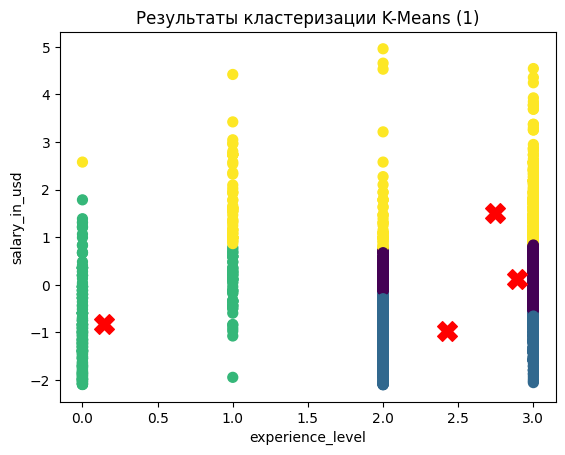

In [26]:
# your_code here

# Визуализируем результаты кластеризации двумерной кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (1)')
plt.show()

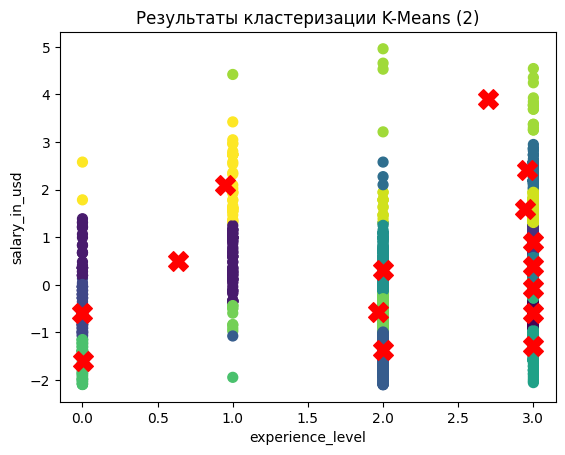

In [27]:
# Визуализируем результаты кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels_2, s=50, cmap='viridis')
plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (2)')
plt.show()

Оптимальное число кластеров 15, с баллом 0.5328061626115616


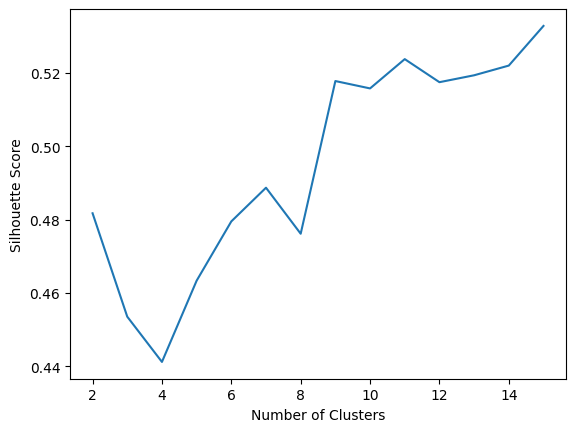

0.5328061626115616


In [28]:
# silhouette score на 16

from sklearn.metrics import silhouette_score

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального K
scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")
# Визуализация результатов
plt.plot(range(2, 16), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

print(score)

Оптимальное число кластеров 10, с баллом 5750.055535230663


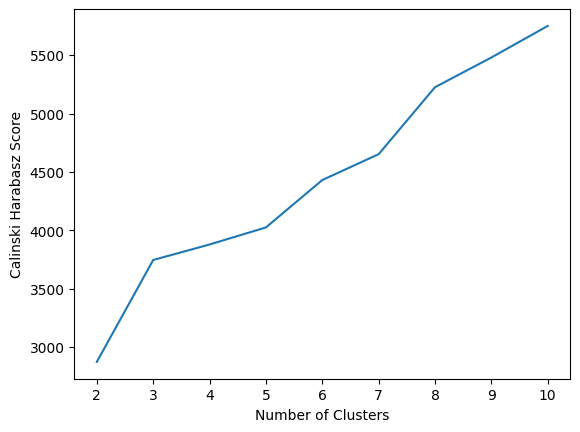

In [29]:
#calinski_harabasz_score на 16
from sklearn.metrics import calinski_harabasz_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    scores.append(score)

print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")

# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [ ]:
"""
Здесь DBSCAN и метрики. Используйте поиск оптимального EPS. Объясните почему?
"""

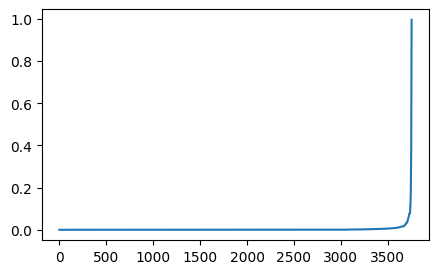

In [30]:
# your_code here

#Находим eps
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

x_scaler = StandardScaler().fit_transform(X)

# Инициализация и обучение модели DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples= 4)
dbscan.fit(x_scaler)

# Получение меток кластеров для каждой точки (-1 означает выбросы)
labels = dbscan.labels_

In [ ]:
"""
Здесь визуализация кластеров DBSCAN
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

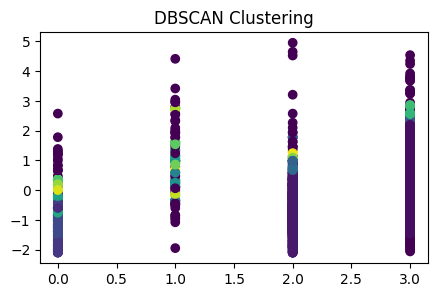

In [32]:
# your_code here

# Визуализация результатов, темные точки - выбросы
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

Оптимальное число кластеров 9, с баллом 0.6255871230347592


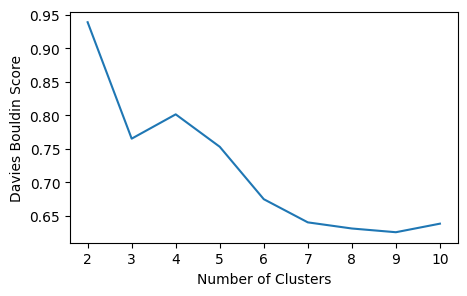

In [33]:
from sklearn.metrics import davies_bouldin_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = davies_bouldin_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(min(scores)) + 2}, с баллом {min(scores)}")
# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

In [ ]:
"""
Здесь иерархическая кластеризация и метрики
"""

In [34]:
# your_code here

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Инициализация и обучение модели иерархической кластеризации
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit(X)

AgglomerativeClustering(n_clusters=4)

In [ ]:
"""
Здесь визуализация кластеров иерархической кластеризации
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

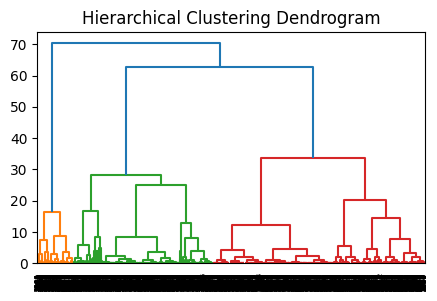

In [35]:
# your_code here

# Визуализация дендрограммы
from scipy.cluster import hierarchy
linkage_matrix = hierarchy.linkage(X, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

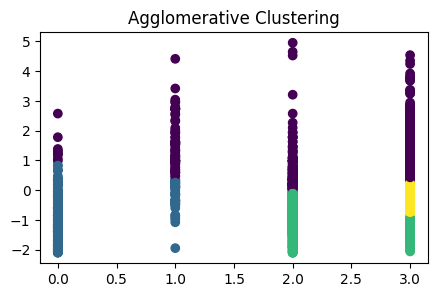

In [36]:
# Визуализация результатов кластеризации
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=agg_clustering.labels_, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.show()

In [37]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=97573b360253f70f40e04e4bc9f4ade72dc476f7a8fe7a7d645bae2f94e4e0a3
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall

Выполните профилирование набора данных относительно кластеров, используя оригинальный набор данных.

P.S. задание для всех

In [ ]:
#
#### Приветсвуется ручной анилиз - гарфики, статистика по разным кластерам, как альтернативный путь решения задачи
#

# 1. в оригинальный набор данных добавьте колонки с кластерами и работаем с ним

"""
df['kmeans_cluster'] = kmeans_cluster.labels_
df['dbsscan_cluster'] = dbsscan_cluster.labels_
...
"""

# 2. Выполните фильтрацию относительно каждого кластера и каждого алгоритма (Внимание, кластер -1 не учитываем в DBSSCAN, тк это выбросы. То есть, точки не вошли ни в одни кластер)
"""
P.S за пример взять 1 тип кластеров, выполните для всех (если кластеров больше 3, разрешено использовать первые три кластера для анализа)

from ydata_profiling import ProfileReport
df['dbscan_labels'] = dbscan.labels_

uniq_labels = tuple(set(dbscan.labels_))

print(uniq_labels)

"""

# 3. Выполните профилирование
"""
На отдельной ячейке выполните профилирование для каждого кластера и каждого алгоритма

from ydata_profiling import ProfileReport

ProfileReport(df[df.dbscan_labels == 0]) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

"""

# 4. Проанализируйте результат по кластерам. Какие переменные попали в каждый кластер, их различия (статистические), графики.
# Постарайтесь объяснить различия "фактически".
# Например, видно, что в кластер 1 у пациентов возраст выше в среднем и в медиане, чем в остальных, что может свидетельствоать о влиянии возраста на кластер №()



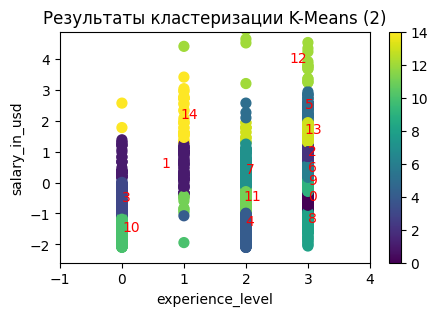

In [38]:
# your_code here

plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels_2, s=50, cmap='viridis')
#plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (2)')
plt.colorbar()
center_marks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# textCoord = [f"{x}" for x in centroidCoords]
x, y = np.array(cluster_centers_2).T

# for i in center_marks:
#   plt.text()

for col, row, t in zip(x, y, center_marks):
    plt.text(col, row, t, fontsize=10, color="red")
plt.xlim(min(x)-1, max(x)+1)
plt.ylim(min(y)-1, max(y)+1)

plt.show()

In [39]:
df['kmeans_cluster'] = cluster_labels_2
cluster_centers_2

array([[ 3.00000000e+00, -5.83704785e-01],
       [ 6.36363636e-01,  5.07177174e-01],
       [ 3.00000000e+00,  8.96691762e-01],
       [-2.66453526e-15, -5.91088292e-01],
       [ 1.99626866e+00, -1.36763102e+00],
       [ 2.95774648e+00,  2.39970279e+00],
       [ 3.00000000e+00,  3.84037327e-01],
       [ 2.00000000e+00,  3.15886815e-01],
       [ 3.00000000e+00, -1.28248944e+00],
       [ 3.00000000e+00, -6.91179661e-02],
       [ 6.28930818e-03, -1.59250388e+00],
       [ 1.96753247e+00, -5.81478905e-01],
       [ 2.70000000e+00,  3.89484464e+00],
       [ 2.94331984e+00,  1.59834556e+00],
       [ 9.50000000e-01,  2.08901903e+00]])

In [40]:
#Значения по кластерам
for i in range(15):
  print("\nКластер ", i, "\n")
  print(df[df['kmeans_cluster'] == i].describe())


Кластер  0 

             salary  salary_in_usd  remote_ratio  kmeans_cluster
count  4.490000e+02     449.000000    449.000000           449.0
mean   1.318029e+05  100769.420935     47.772829             0.0
std    4.771095e+05   10758.724625     49.388511             0.0
min    6.500400e+04   79197.000000      0.000000             0.0
25%    9.032000e+04   92350.000000      0.000000             0.0
50%    1.015700e+05  102500.000000      0.000000             0.0
75%    1.100000e+05  110000.000000    100.000000             0.0
max    7.500000e+06  116450.000000    100.000000             0.0

Кластер  1 

              salary  salary_in_usd  remote_ratio  kmeans_cluster
count      99.000000      99.000000     99.000000            99.0
mean   169542.898990  169546.505051     36.868687             1.0
std     30270.615282   28686.856680     47.156848             0.0
min    104891.000000  115000.000000      0.000000             1.0
25%    150000.000000  150000.000000      0.000000        

In [41]:
import seaborn as sns

<ipython-input-42-c33e34579ecd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 0].corr()


<Axes: >

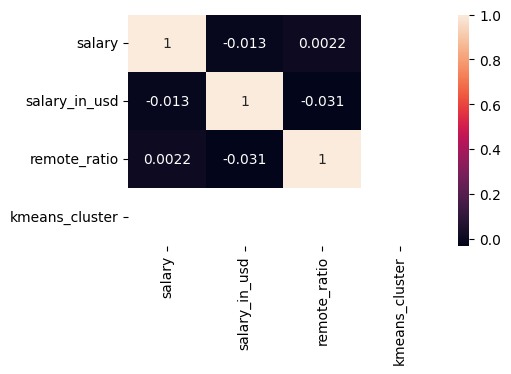

In [42]:
#Корреляция в кластере 0
corr_matrix = df[df['kmeans_cluster'] == 0].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-43-f07ccf053762>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 1].corr()


<Axes: >

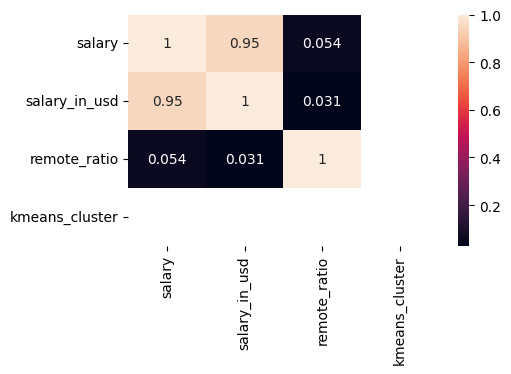

In [43]:
#Корреляция в кластере 1
corr_matrix = df[df['kmeans_cluster'] == 1].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-44-184b5e2fc7fb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 2].corr()


<Axes: >

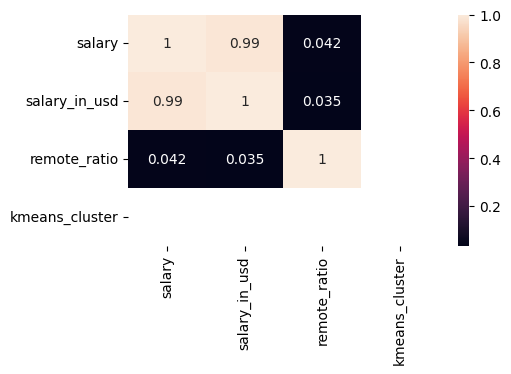

In [44]:
#Корреляция в кластере 2
corr_matrix = df[df['kmeans_cluster'] == 2].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-45-ed18cd5ffe27>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 3].corr()


<Axes: >

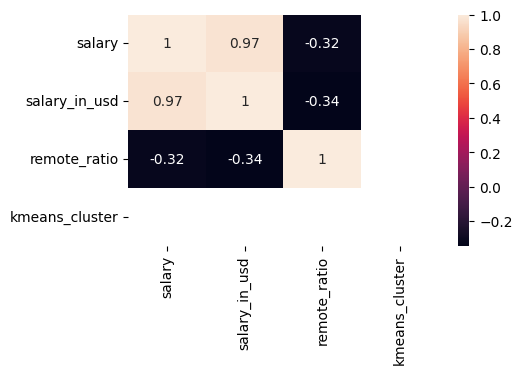

In [45]:
#Корреляция в кластере 3
corr_matrix = df[df['kmeans_cluster'] == 3].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-46-c55647e43662>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 4].corr()


<Axes: >

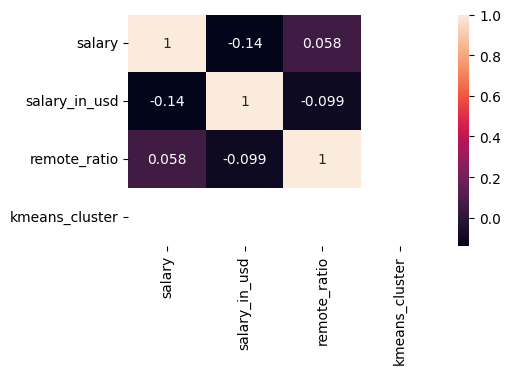

In [46]:
#Корреляция в кластере 4
corr_matrix = df[df['kmeans_cluster'] == 4].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-47-55ceb1927ada>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 5].corr()


<Axes: >

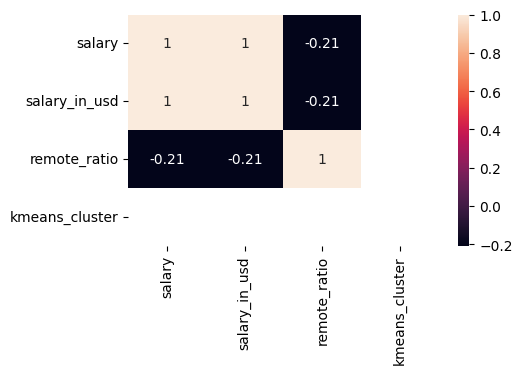

In [47]:
#Корреляция в кластере 5
corr_matrix = df[df['kmeans_cluster'] == 5].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-48-f9ca5c5d227e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 6].corr()


<Axes: >

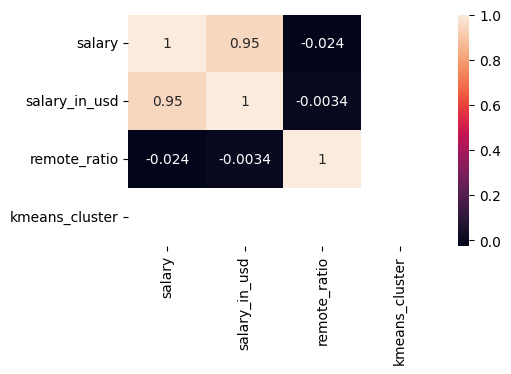

In [48]:
#Корреляция в кластере 6
corr_matrix = df[df['kmeans_cluster'] == 6].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-51-1aea0c8555ea>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 7].corr()


<Axes: >

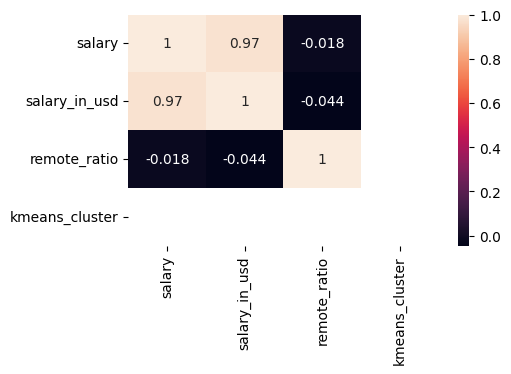

In [51]:
#Корреляция в кластере 7
corr_matrix = df[df['kmeans_cluster'] == 7].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-49-a9ea2476012e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 8].corr()


<Axes: >

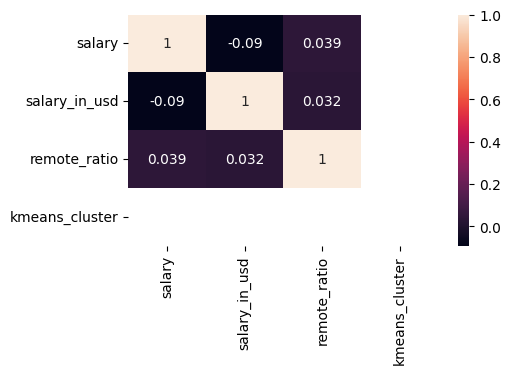

In [49]:
#Корреляция в кластере 8
corr_matrix = df[df['kmeans_cluster'] == 8].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-50-0fe74c6f2afa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 9].corr()


<Axes: >

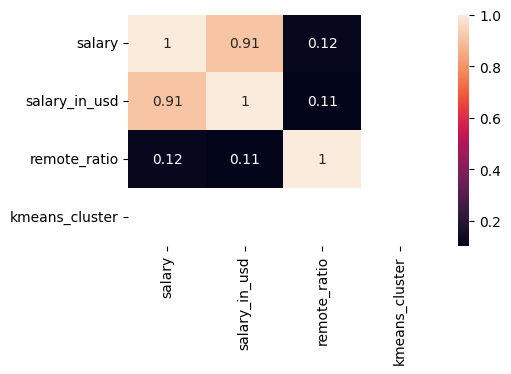

In [50]:
#Корреляция в кластере 9
corr_matrix = df[df['kmeans_cluster'] == 9].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-52-aa670056e13e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 10].corr()


<Axes: >

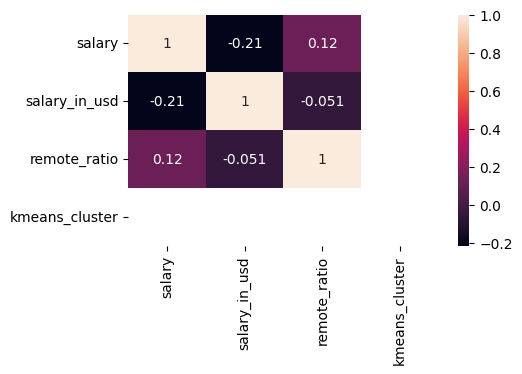

In [52]:
#Корреляция в кластере 10
corr_matrix = df[df['kmeans_cluster'] == 10].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-53-72dce90a938d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 11].corr()


<Axes: >

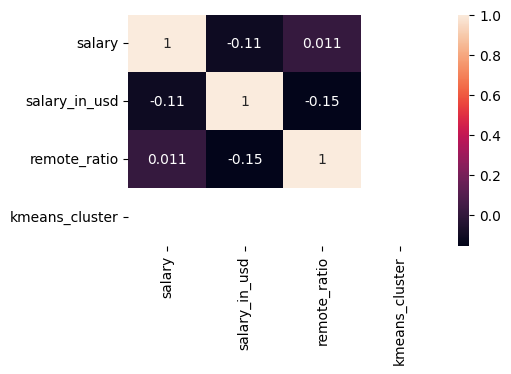

In [53]:
#Корреляция в кластере 11
corr_matrix = df[df['kmeans_cluster'] == 11].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-54-4bf411137696>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 12].corr()


<Axes: >

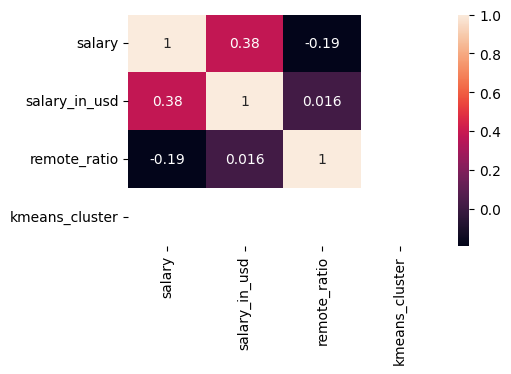

In [54]:
#Корреляция в кластере 12
corr_matrix = df[df['kmeans_cluster'] == 12].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-55-2d009b956c28>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 13].corr()


<Axes: >

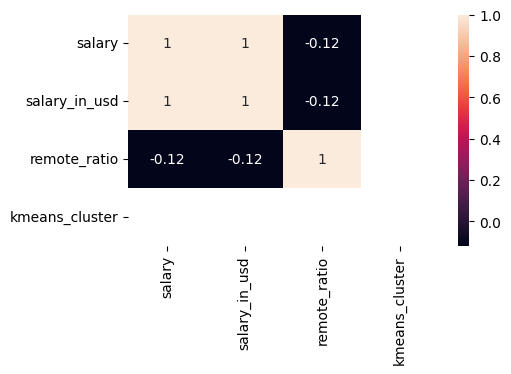

In [55]:
#Корреляция в кластере 13
corr_matrix = df[df['kmeans_cluster'] == 13].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-56-729c71a56b61>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 14].corr()


<Axes: >

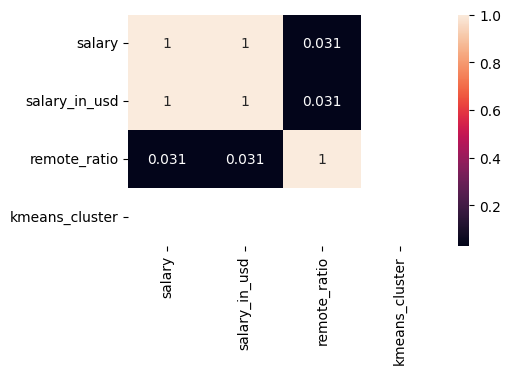

In [56]:
#Корреляция в кластере 14
corr_matrix = df[df['kmeans_cluster'] == 14].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-57-a6fd76bbdac0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 15].corr()
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

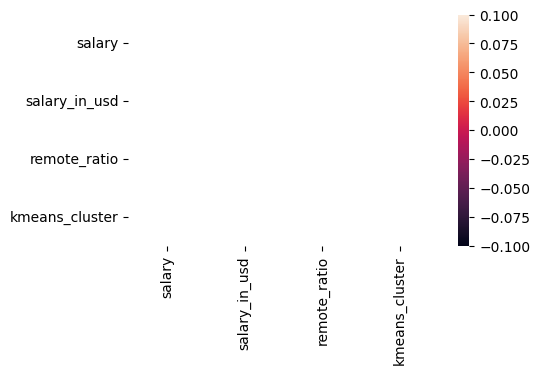

In [57]:
#Корреляция в кластере 15
corr_matrix = df[df['kmeans_cluster'] == 15].corr()
sns.heatmap(corr_matrix, annot=True)

# **Вывод**
В графике, отображающем отношение salary_in_usd к experience_year, выделяются несколько значительных кластеров: 10 (высокие показатели за 1, 2 и 3 года опыта), 11 (верхняя половина показателей за 1 год, самые высокие значения за 0 лет опыта, а также несколько лучших в категории 2) и 9 (верхняя треть за 0 лет, средние значения за 1 год).

Обратив внимание на корреляцию, можно заключить, что 11-й кластер представлен данными сотрудников из США, поскольку корреляция между salary и salary_in_usd  равна 1. Кластер 9 включает в себя сотрудников из Европейского союза, где используется евро, и разница в стоимости с долларом невелика. Кластер 10 объединяет данные из разных компаний, что подтверждается низкой корреляцией по сравнению с предыдущими кластерами.

Оценивая числовые показатели кластеров, можно сделать вывод, что кластер 9 является наиболее точным среди тройки, поскольку содержит наибольшее количество данных.

Таким образом, вышеописанные наблюдения указывают на то, что для обучения лучше всего использовать данные из кластера 9.